<a href="https://colab.research.google.com/github/graviraja/100-Days-of-NLP/blob/applications%2Fquestion-answering/applications/question-answering/Basic%20Visual%20Question%20Answering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### DAQUAR dataset

In [4]:
!wget http://datasets.d2.mpi-inf.mpg.de/mateusz14visual-turing/nyu_depth_images.tar

--2020-08-01 16:02:22--  http://datasets.d2.mpi-inf.mpg.de/mateusz14visual-turing/nyu_depth_images.tar
Resolving datasets.d2.mpi-inf.mpg.de (datasets.d2.mpi-inf.mpg.de)... 139.19.86.170
Connecting to datasets.d2.mpi-inf.mpg.de (datasets.d2.mpi-inf.mpg.de)|139.19.86.170|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://datasets.d2.mpi-inf.mpg.de/mateusz14visual-turing/nyu_depth_images.tar [following]
--2020-08-01 16:02:22--  https://datasets.d2.mpi-inf.mpg.de/mateusz14visual-turing/nyu_depth_images.tar
Connecting to datasets.d2.mpi-inf.mpg.de (datasets.d2.mpi-inf.mpg.de)|139.19.86.170|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 431144960 (411M) [application/x-tar]
Saving to: ‘nyu_depth_images.tar’

nyu_depth_images.ta 100%[===================>] 411.17M   109MB/s    in 3.9s    

2020-08-01 16:02:26 (105 MB/s) - ‘nyu_depth_images.tar’ saved [431144960/431144960]



In [7]:
!tar -xf nyu_depth_images.tar

In [16]:
!wget http://datasets.d2.mpi-inf.mpg.de/mateusz14visual-turing/qa.894.raw.train.txt
!wget http://datasets.d2.mpi-inf.mpg.de/mateusz14visual-turing/qa.894.raw.test.txt
!wget http://datasets.d2.mpi-inf.mpg.de/mateusz14visual-turing/train.txt
!wget http://datasets.d2.mpi-inf.mpg.de/mateusz14visual-turing/test.txt

--2020-08-01 16:25:51--  http://datasets.d2.mpi-inf.mpg.de/mateusz14visual-turing/qa.894.raw.train.txt
Resolving datasets.d2.mpi-inf.mpg.de (datasets.d2.mpi-inf.mpg.de)... 139.19.86.170
Connecting to datasets.d2.mpi-inf.mpg.de (datasets.d2.mpi-inf.mpg.de)|139.19.86.170|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://datasets.d2.mpi-inf.mpg.de/mateusz14visual-turing/qa.894.raw.train.txt [following]
--2020-08-01 16:25:51--  https://datasets.d2.mpi-inf.mpg.de/mateusz14visual-turing/qa.894.raw.train.txt
Connecting to datasets.d2.mpi-inf.mpg.de (datasets.d2.mpi-inf.mpg.de)|139.19.86.170|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 423888 (414K) [text/plain]
Saving to: ‘qa.894.raw.train.txt’

qa.894.raw.train.tx 100%[===================>] 413.95K  --.-KB/s    in 0.1s    

2020-08-01 16:25:51 (4.09 MB/s) - ‘qa.894.raw.train.txt’ saved [423888/423888]

--2020-08-01 16:25:54--  http://datasets.d2.mpi-inf.mpg.de/mateu

In [17]:
!ls

nyu_depth_images      qa.894.raw.test.txt   sample_data  train.txt
nyu_depth_images.tar  qa.894.raw.train.txt  test.txt


### Imports

In [179]:
import os
import re
import nltk
import time
import numpy as np

from PIL import Image
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.models as models
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Data Exploration

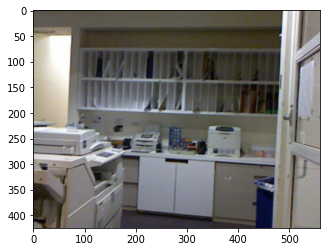

In [13]:
image_path = 'nyu_depth_images/image10.png'
image = Image.open(image_path)
plt.imshow(np.asarray(image))

In [70]:
with open('train.txt') as f:
    train_image_names = f.readlines()

with open('test.txt') as f:
    test_image_names = f.readlines()

In [71]:
len(train_image_names), len(test_image_names)

(795, 654)

In [72]:
with open('qa.894.raw.train.txt') as f:
    train_qa = f.readlines()

with open('qa.894.raw.test.txt') as f:
    test_qa = f.readlines()

In [146]:
train_ques = []
train_imgs = []
train_ans = []

test_ques = []
test_imgs = []
test_ans = []

for i in range(0, len(train_qa), 2):
    ques = train_qa[i]
    toks = ques.split()
    img = toks[-2]
    if not img.startswith('image'):
        continue
    # remove the end tokens: in the <img> ?
    toks = toks[:-4] + ["?"]
    question = " ".join(toks).strip()
    train_imgs.append(img)
    train_ques.append(question)
    train_ans.append(train_qa[i+1])

for i in range(0, len(test_qa), 2):
    ques = test_qa[i]
    toks = ques.split()
    img = toks[-2]
    if not img.startswith('image'):
        continue
    # remove the end tokens: in the <img> ?
    toks = toks[:-4] + ["?"]
    question = " ".join(toks).strip()
    test_imgs.append(img)
    test_ques.append(question)
    test_ans.append(test_qa[i+1])

In [147]:
len(train_imgs), len(train_ques), len(train_ans)

(6794, 6794, 6794)

In [148]:
valid_imgs, test_imgs, valid_ques, test_ques, valid_ans, test_ans = train_test_split(test_imgs, test_ques, test_ans, test_size=0.5, random_state=42)

In [149]:
len(valid_imgs), len(valid_ques), len(valid_ans), len(test_imgs), len(test_ques), len(test_ans)

(2836, 2836, 2836, 2837, 2837, 2837)

In [150]:
len(set(train_imgs)), len(set(test_imgs + valid_imgs))

(794, 653)

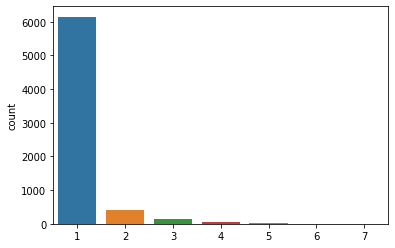

In [151]:
ans_lengths = [len(ans.split()) for ans in train_ans]
sns.countplot(ans_lengths)

Question: what is on the right side of the black telephone and on the left side of the red chair ?
Answer: desk



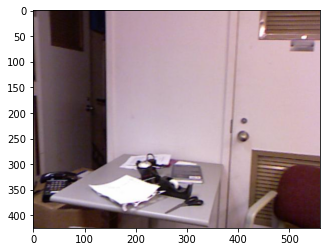

In [79]:
ques = train_ques[0]
ans = train_ans[0]
image_path = f"nyu_depth_images/{train_imgs[0]}.png"
image = Image.open(image_path)
plt.imshow(np.asarray(image))
print(f"Question: {ques}")
print(f"Answer: {ans}")

Question: what is on the left side of the cabinet and on the right side of the chair ?
Answer: whiteboard



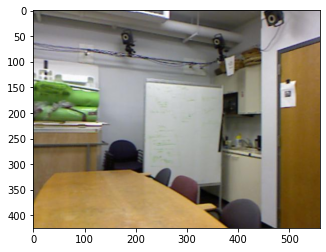

In [80]:
ques = train_ques[10]
ans = train_ans[10]
image_path = f"nyu_depth_images/{train_imgs[10]}.png"
image = Image.open(image_path)
plt.imshow(np.asarray(image))
print(f"Question: {ques}")
print(f"Answer: {ans}")

### Image Processing

In [81]:
def resize_image(image, size):
    return image.resize(size, Image.ANTIALIAS)

def resize_images(input_dir, output_dir, size):
    images = os.listdir(input_dir)
    n_images = len(images)
    for iimage, image in enumerate(images):
        try:
            with open(os.path.join(input_dir, image), 'r+b') as f:
                with Image.open(f) as img:
                    img = resize_image(img, size)
                    img.save(os.path.join(output_dir, image), img.format)
        except(IOError, SyntaxError) as e:
            pass
        if (iimage+1) % 100 == 0:
            print("[{}/{}] Resized the images and saved into '{}'."
                    .format(iimage+1, n_images, output_dir))

In [85]:
!mkdir processed_images

In [86]:
size = [224, 224]
input_dir = 'nyu_depth_images'
output_dir = 'processed_images'
resize_images(input_dir, output_dir, size)

[100/1449] Resized the images and saved into 'processed_images'.
[200/1449] Resized the images and saved into 'processed_images'.
[300/1449] Resized the images and saved into 'processed_images'.
[400/1449] Resized the images and saved into 'processed_images'.
[500/1449] Resized the images and saved into 'processed_images'.
[600/1449] Resized the images and saved into 'processed_images'.
[700/1449] Resized the images and saved into 'processed_images'.
[800/1449] Resized the images and saved into 'processed_images'.
[900/1449] Resized the images and saved into 'processed_images'.
[1000/1449] Resized the images and saved into 'processed_images'.
[1100/1449] Resized the images and saved into 'processed_images'.
[1200/1449] Resized the images and saved into 'processed_images'.
[1300/1449] Resized the images and saved into 'processed_images'.
[1400/1449] Resized the images and saved into 'processed_images'.


In [164]:
train_imgs = [f"processed_images/{img}.png" for img in train_imgs]
valid_imgs = [f"processed_images/{img}.png" for img in valid_imgs]
test_imgs = [f"processed_images/{img}.png" for img in test_imgs]

Question: what is in front of the stacked chairs and on the left side of the table ?
Answer: ladder



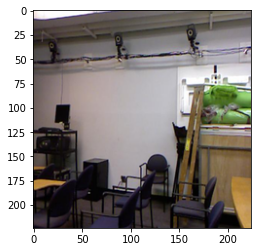

In [165]:
ques = train_ques[15]
ans = train_ans[15]
image_path = train_imgs[15]
image = Image.open(image_path)
plt.imshow(np.asarray(image))
print(f"Question: {ques}")
print(f"Answer: {ans}")

### Vocabulary

In [152]:
class Vocabulary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [153]:
def build_vocab(sentences, threshold=5):
    """Build a simple vocabulary wrapper."""
    counter = Counter()
    for i, sent in enumerate(sentences):
        tokens = sent.lower().split()
        counter.update(tokens)

        if (i+1) % 1000 == 0:
            print("[{}/{}] Tokenized.".format(i+1, len(sentences)))

    # If the word frequency is less than 'threshold', then the word is discarded.
    words = [word for word, cnt in counter.items() if cnt >= threshold]

    # Create a vocab wrapper and add some special tokens.
    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')

    # Add the words to the vocabulary.
    for i, word in enumerate(words):
        vocab.add_word(word)
    return vocab

In [154]:
ques_vocab = build_vocab(train_ques)
ans_vocab = build_vocab(train_ans)

[1000/6794] Tokenized.
[2000/6794] Tokenized.
[3000/6794] Tokenized.
[4000/6794] Tokenized.
[5000/6794] Tokenized.
[6000/6794] Tokenized.
[1000/6794] Tokenized.
[2000/6794] Tokenized.
[3000/6794] Tokenized.
[4000/6794] Tokenized.
[5000/6794] Tokenized.
[6000/6794] Tokenized.


### VQA Dataset

In [155]:
class VQADataset(data.Dataset):
    def __init__(self, imgs, ques, ans, transform=None):
        self.imgs = imgs
        self.ques = ques
        self.ans = ans
        self.transform = transform
    
    def __len__(self):
        return len(self.ques)
    
    def __getitem__(self, item):
        img = self.imgs[item]
        ques = self.ques[item]
        ans = self.ans[item]

        image = Image.open(img).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        
        q_tokens = str(ques).lower().split()
        # consider only the first token as the 90% of the data contains only 1 token as answer
        a_token = str(ans).lower().split()[0]

        question = []
        question.append(ques_vocab('<start>'))
        question.extend([ques_vocab(token) for token in q_tokens])
        question.append(ques_vocab('<end>'))
        
        question = torch.Tensor(question)

        answer = [ans_vocab(a_token)]        
        answer = torch.Tensor(answer)

        return image, question, answer

In [156]:
transform = transforms.Compose([ 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                            (0.229, 0.224, 0.225))])

In [166]:
train_dataset = VQADataset(train_imgs, train_ques, train_ans, transform)
valid_dataset = VQADataset(valid_imgs, valid_ques, valid_ans, transform)
test_dataset = VQADataset(test_imgs, test_ques, test_ans, transform)

In [167]:
train_dataset[0]

(tensor([[[-0.6452, -0.9534, -0.6623,  ..., -0.0972, -0.0972, -0.1314],
          [-0.6623, -0.8678, -0.5767,  ..., -0.2171, -0.1999, -0.2856],
          [-0.6281, -0.6794, -0.4568,  ...,  0.0227,  0.0227,  0.0398],
          ...,
          [-0.8507, -0.8164, -0.7822,  ..., -1.3644, -1.3302, -1.2959],
          [-1.0048, -0.9192, -0.8164,  ..., -1.4158, -1.3987, -1.3644],
          [-1.3473, -1.1075, -0.9192,  ..., -1.4672, -1.4329, -1.3987]],
 
         [[-0.8102, -1.1779, -0.9153,  ..., -0.5826, -0.5826, -0.6527],
          [-0.8627, -1.1078, -0.8452,  ..., -0.7227, -0.7577, -0.8803],
          [-0.8452, -0.9503, -0.7402,  ..., -0.4951, -0.5826, -0.6352],
          ...,
          [-1.0728, -1.0728, -1.0728,  ..., -1.8431, -1.7906, -1.7556],
          [-1.1779, -1.1429, -1.1253,  ..., -1.8782, -1.8606, -1.8256],
          [-1.4755, -1.3004, -1.2304,  ..., -1.8957, -1.8782, -1.8606]],
 
         [[-0.7936, -0.9853, -0.5844,  ..., -0.7238, -0.7064, -0.6367],
          [-0.6890, -0.8110,

### DataLoaders

In [159]:
def collate_fn(data):
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, questions, answers = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge questions (from tuple of 1D tensor to 2D tensor).
    ques_lengths = [len(ques) for ques in questions]
    qs = torch.zeros(len(questions), max(ques_lengths)).long()
    for i, ques in enumerate(questions):
        end = ques_lengths[i]
        qs[i, :end] = ques[:end]

    # Merge answers (from tuple of 1D tensor to 2D tensor).
    ans_lengths = [len(ans) for ans in answers]
    anss = torch.zeros(len(answers), max(ans_lengths)).long()
    for i, ans in enumerate(answers):
        end = ans_lengths[i]
        anss[i, :end] = ans[:end]

    return images, qs, ques_lengths, anss, ans_lengths


In [168]:
train_data_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=32,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn)

valid_data_loader = torch.utils.data.DataLoader(
    dataset=valid_dataset, 
    batch_size=32,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn)

test_data_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, 
    batch_size=32,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn)

In [169]:
# sample check
sample = next(iter(train_data_loader))

In [170]:
sample[0].shape, sample[1].shape, len(sample[2]), sample[3].shape, len(sample[4])

(torch.Size([32, 3, 224, 224]),
 torch.Size([32, 16]),
 32,
 torch.Size([32, 1]),
 32)

### Image Encoder

In [113]:
class ImageEncoder(nn.Module):
    def __init__(self, embed_size):
        super().__init__()

        model = models.vgg19(pretrained=True)
        in_features = model.classifier[-1].in_features
        model.classifier = nn.Sequential(
            *list(model.classifier.children())[:-1]
        )
        self.model = model
        self.fc = nn.Linear(in_features, embed_size)
    
    def forward(self, image):
        with torch.no_grad():
            img_features = self.model(image)
            # img_features => [batch_size, in_features]
        img_features = self.fc(img_features)
        # img_features => [batch_size, embed_size]

        return img_features

### Question Encoder

In [137]:
class QuestionEncoder(nn.Module):
    def __init__(self, vocab_size, word_emb_dim, embed_size, num_layers, hid_dim, dropout=0.3):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, word_emb_dim)
        self.lstm = nn.LSTM(word_emb_dim, hid_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(2 * num_layers * hid_dim, embed_size)

        self.dropout = nn.Dropout(dropout)

    def forward(self, question):
        # question => [batch_size, seq_len]

        embed = self.embedding(question)
        embed = self.dropout(embed)
        batch_size = question.size(0)
        # embed => [batch_size, seq_len, emb_dim]

        _, (hidden, cell) = self.lstm(embed)
        # hidden, cell => [2, batch_size, hid_dim]

        ques_feature = torch.cat((hidden, cell), 2)
        # ques_feature => [2, batch_size, hid_dim * 2]

        ques_feature = ques_feature.transpose(0, 1)
        # ques_feature => [batch_size, 2, hid_dim * 2]

        ques_feature = ques_feature.contiguous().view(batch_size, -1)
        # ques_feature => [batch_size, 2 * hid_dim * 2]

        ques_feature = self.dropout(ques_feature.tanh())
        # ques_feature => [batch_size, 2 * hid_dim * 2]

        ques_feature = self.fc(ques_feature)
        # ques_feature => [batch_size, embed_size]

        return ques_feature

### VQA

In [138]:
class VQA(nn.Module):
    def __init__(self, embed_size, vocab_size, ans_vocab_size, word_emb_size, num_layers, hidden_size, dropout=0.3):
        super().__init__()

        self.image_encoder = ImageEncoder(embed_size)
        self.ques_encoder = QuestionEncoder(vocab_size, word_emb_size, embed_size, num_layers, hidden_size)

        self.fc1 = nn.Linear(embed_size, ans_vocab_size)
        self.fc2 = nn.Linear(ans_vocab_size, ans_vocab_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, images, questions):
        # images =>
        # questions => 

        encoded_images = self.image_encoder(images)
        # encoded_images => [batch_size, embed_size]

        encoded_ques = self.ques_encoder(questions)
        # encoded_ques => [batch_size, embed_size]

        combined = encoded_images * encoded_ques
        # combined => [batch_size, embed_size]

        combined = self.dropout(combined.tanh())
        # combined => [batch_size, embed_size]

        hidden = self.fc1(combined)
        hidden = self.dropout(hidden.tanh())
        # hidden => [batch_size, ans_vocab_size]

        out = self.fc2(hidden)
        # out => [batch_size, ans_vocab_size]

        return out

### Model

In [202]:
embed_size = 300
vocab_size = len(ques_vocab)
ans_vocab_size = len(ans_vocab)
word_embed_size = 50
num_layers = 2
hidden_size = 128

model = VQA(embed_size, vocab_size, ans_vocab_size, word_embed_size, num_layers, hidden_size)
model.to(device)

VQA(
  (image_encoder): ImageEncoder(
    (model): VGG(
      (features): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace=True)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace=True)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace=True)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace=True)
        (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 

### Loss & Optimizer

In [203]:
lr = 1e-2
min_lr = 3e-4
lr_decay=0.5
lr_patience=2

In [204]:
criterion = nn.CrossEntropyLoss()
params = list(model.image_encoder.fc.parameters()) + list(model.ques_encoder.parameters()) + list(model.fc1.parameters()) + list(model.fc2.parameters())
optimizer = torch.optim.Adam(params, lr=lr)
scheduler = ReduceLROnPlateau(optimizer, 'min', lr_decay, lr_patience, verbose=True, min_lr=min_lr)

### Training Method

In [177]:
log_step = 50

In [142]:
def train(model, data_loader):
    model.train()
    epoch_loss = 0
    total_steps = len(data_loader)
    
    for i, (images, questions, _, answers, _) in enumerate(data_loader):
        # zero the gradients
        optimizer.zero_grad()

        images = images.to(device)
        questions = questions.to(device)
        answers = answers.to(device)

        # forward pass
        output = model(images, questions)

        # loss
        loss = criterion(output, answers.squeeze(1))
        epoch_loss += loss.item()
        
        # backward pass
        loss.backward()

        # clip the gradients
        torch.nn.utils.clip_grad_norm_(params, 5.)

        # update parameters
        optimizer.step()

        # Print log info
        if i % log_step == 0:
            print(f'Step [{i}/{total_steps}], Loss: {loss.item():.4f}') 
            
    return epoch_loss / total_steps

### Evaluation Method

In [178]:
def evaluate(model, data_loader):
    model.eval()
    epoch_loss = 0

    total_steps = len(data_loader)
    
    with torch.no_grad():
        for i, (images, questions, _, answers, _) in enumerate(data_loader):
            images = images.to(device)
            questions = questions.to(device)
            answers = answers.to(device)

            # forward pass
            output = model(images, questions)

            # loss
            loss = criterion(output, answers.squeeze(1))
            epoch_loss += loss.item()

            # Print log info
            if i % log_step == 0:
                print(f'Val Step [{i}/{total_steps}], Loss: {loss.item():.4f}') 
            
    return epoch_loss / total_steps

### Training

In [144]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [205]:
num_epochs = 50

best_valid_loss = float('inf')
for epoch in range(num_epochs):  
    
    start_time = time.time()
    train_loss = train(model, train_data_loader)
    val_loss = evaluate(model, valid_data_loader)
    end_time = time.time()

    scheduler.step(val_loss)
    elapsed_mins, elapsed_secs = epoch_time(start_time, end_time)

    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(model.state_dict(), 'model.pt')

    print(f"Epoch: {epoch+1:02} | Time: {elapsed_mins}m {elapsed_secs}s")
    print(f"\t Train Loss: {train_loss:.3f} | Valid Loss: {val_loss:.3f}")

Step [0/213], Loss: 5.5265
Step [50/213], Loss: 4.9783
Step [100/213], Loss: 5.2752
Step [150/213], Loss: 6.6333
Step [200/213], Loss: 6.6520
Val Step [0/89], Loss: 5.1279
Val Step [50/89], Loss: 5.5622
Epoch: 01 | Time: 0m 37s
	 Train Loss: 6.131 | Valid Loss: 5.632
Step [0/213], Loss: 6.1541
Step [50/213], Loss: 6.1207
Step [100/213], Loss: 6.1435
Step [150/213], Loss: 5.9326
Step [200/213], Loss: 5.6407
Val Step [0/89], Loss: 6.1639
Val Step [50/89], Loss: 6.8319
Epoch: 02 | Time: 0m 38s
	 Train Loss: 6.339 | Valid Loss: 5.786
Step [0/213], Loss: 6.3193
Step [50/213], Loss: 5.2859
Step [100/213], Loss: 6.7277
Step [150/213], Loss: 6.3542
Step [200/213], Loss: 6.5212
Val Step [0/89], Loss: 4.9645
Val Step [50/89], Loss: 5.8519
Epoch: 03 | Time: 0m 37s
	 Train Loss: 6.389 | Valid Loss: 5.506
Step [0/213], Loss: 6.7132
Step [50/213], Loss: 6.4676
Step [100/213], Loss: 5.8562
Step [150/213], Loss: 6.5627
Step [200/213], Loss: 5.2861
Val Step [0/89], Loss: 5.2469
Val Step [50/89], Loss: 

In [206]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [207]:
transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])

def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image


In [239]:
def inference(image_path, question):
    # Prepare an image
    image = load_image(image_path, transform)
    image_tensor = image.to(device)
    
    q_tokens = str(question).lower().split()
    ques = []
    ques.append(ques_vocab('<start>'))
    ques.extend([ques_vocab(token) for token in q_tokens])
    ques.append(ques_vocab('<end>'))
    
    ques_tensor = torch.LongTensor(ques).to(device)
    ques_tensor = ques_tensor.unsqueeze(0)

    # Generate an caption from the image
    logits = model(image_tensor, ques_tensor)
    scores, preds = logits[0].topk(3, 0, True, True)

    # Print out the image and the generated caption
    image = Image.open(image_path)
    plt.imshow(np.asarray(image))
    print(question)
    print('-'*50)
    for score, val in zip(scores, preds):
        answer = ans_vocab.idx2word[val.item()]
        if answer == "<unk>":
            continue
        print(f"Pred: {answer}, score: {score.item()}")
    print('-'*50)

how many black chairs are behind the coffee table ?
--------------------------------------------------
Pred: table, score: 0.4794585704803467
Pred: 2, score: 0.4656873941421509
--------------------------------------------------
Actual: 2



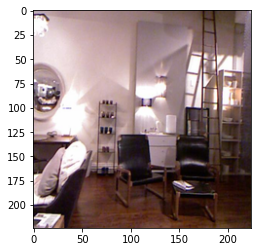

In [240]:
img = train_imgs[150]
ques = train_ques[150]
ans = train_ans[150]

inference(img, ques)
print(f"Actual: {ans}")

what is the colour of the bath tub ?
--------------------------------------------------
Pred: 2, score: 0.7022167444229126
Pred: white, score: 0.39760997891426086
--------------------------------------------------
Actual: white



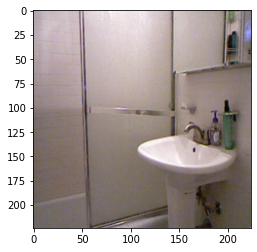

In [242]:
img = train_imgs[1600]
ques = train_ques[1600]
ans = train_ans[1600]

inference(img, ques)
print(f"Actual: {ans}")

what is behind the bed ?
--------------------------------------------------
Pred: table, score: 1.0474337339401245
Pred: 2, score: 0.697864830493927
--------------------------------------------------
Actual: telescope



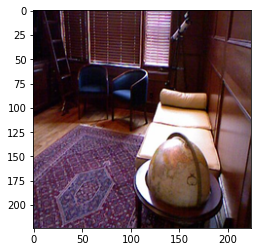

In [246]:
img = train_imgs[4500]
ques = train_ques[4500]
ans = train_ans[4500]

inference(img, ques)
print(f"Actual: {ans}")